## autoMl workflow testing on HomeCredit data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.feature_selection import VarianceThreshold,chi2

%matplotlib inline



pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.max_info_columns',1000)

### aquire the application data

In [2]:
application_train = pd.read_csv('../application_train.csv')
application_test = pd.read_csv('../application_test.csv')
all_data = pd.read_csv('application_assemble.csv')

In [3]:
train_size = application_train.shape[0]
test_size = application_test.shape[0]

In [4]:
print ('the data size of application_train is {}'.format(application_train.shape))
print ('the data size of application_test is {}'.format(application_test.shape))
print ('the data size of application_assemble is {}'.format(all_data.shape))

the data size of application_train is (307511, 122)
the data size of application_test is (48744, 121)
the data size of application_assemble is (356255, 151)


application_assemble is the result data from former data processing, the amount of application_assemble is the sum of train and test data with some new features recreated from bureau,bureau_balance,pos_balance,installments and so on.

### look at the balance of the 0/1 label,we can see imbalance will be a potential problem influence the classifying result,we just set it aside temprorarily

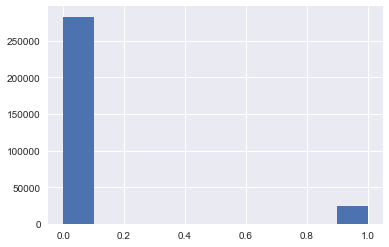

In [5]:
application_train['TARGET'].hist()

### remain some necessary variables

In [6]:
application_train_target = application_train['TARGET']
application_train.drop(['SK_ID_CURR', 'TARGET'], axis=1, inplace=True)

In [7]:
application_test_id = application_test['SK_ID_CURR']
application_test.drop(['SK_ID_CURR'], axis=1, inplace=True)

### Then let's begin a autoML workflow I wanna try, now let's also imagine that we don't know any bussines info about this problem, we just define some common disciplines below  

1 feature processing
* drop the the columns with more than 30 percent NA values, we will set the percent number it as an argument or global variable in project when assembling this workflow as a package
*  fillNa by when int/float then mean, when object then mode 
* drop the unnecessary columns
> if the columns is int or float then remains,if it is a object then drop it when the number of unique values over 10. and also we can set the number as an argument or global variable 
* check if the int/float is large enough then log it

In [8]:
columns_NA_percent = OrderedDict()
for columns in all_data.columns:
    df_na = all_data[columns].isnull()
    na_percent = df_na[df_na == True].shape[0]/df_na.shape[0]
    columns_NA_percent[columns] = na_percent

In [9]:
for k,v in columns_NA_percent.items():
    if v >= 0.3:
        all_data.drop([k], axis=1, inplace=True)

In [10]:
columns_NA_fill_train = OrderedDict()
for columns in all_data.columns:
    dtypes = all_data[columns].dtype.name
    if 'int' in dtypes or 'float' in dtypes:
        columns_NA_fill_train[columns] = all_data[columns].mean()
        continue
    if dtypes == 'object':
        columns_NA_fill_train[columns] = all_data[columns].mode()[0]
        continue
    print ('{} is not found dtypes'.format(dtypes))

In [11]:
all_data = all_data.fillna(columns_NA_fill_train)

In [12]:
def get_unique_dict(df):
    object_columns_dict = OrderedDict()
    for columns in df.dtypes[df.dtypes=='object'].index:
        object_columns_dict[columns] = df[columns].unique()
    return object_columns_dict

In [13]:
object_columns_dict = get_unique_dict(all_data)

In [14]:
for k,v in object_columns_dict.items():
    if len(v) >= 10:
        all_data.drop([k], axis=1, inplace=True)

In [15]:
all_data.head()

,Unnamed: 0,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,bureau_status_Active_counts,bureau_status_Bad debt_counts,bureau_status_Closed_counts,bureau_status_Sold_counts,BUREAU_COUNTS,BUREAU_DAYS_CREDIT,BUREAU_CREDIT_DAY_OVERDUE,BUREAU_CNT_CREDIT_PROLONG,BUREAU_AMT_CREDIT_SUM,BUREAU_AMT_CREDIT_SUM_OVERDUE,BUREAU_DAYS_CREDIT_UPDATE,POS_CASH_balance_counts,POS_SK_DPD_SUM,POS_SK_DPD_DEF_SUM,CREDIT_CARD_COUNTS,INSTALLMENTS_COUNTS,PREVIOUS_Cash loans_counts,PREVIOUS_Consumer loans_counts,PREVIOUS_Revolving loans_counts,PREVIOUS_FRIDAY_COUNTS,PREVIOUS_MONDAY_COUNTS,PREVIOUS_SATURDAY_COUNTS,PREVIOUS_SUNDAY_COUNTS,PREVIOUS_THURSDAY_COUNTS,PREVIOUS_TUESDAY_COUNTS,PREVIOUS_WEDNESDAY_COUNTS,PREVIOUS_APPROVED_COUNTS,PREVIOUS_REFUSED_COUNTS,PREVIOUS_APPLICATION_COUNTS
0,0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,12.023741,1,1,0,1,1,0,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.024700,0.036900,0.972200,0.619200,0.014300,0.000000,0.069000,0.083300,0.125000,0.036900,0.020200,0.019000,0.000000,0.000000,0.025200,0.03830,0.972200,0.634100,0.01440,0.000000,0.069000,0.083300,0.125000,0.037700,0.022000,0.019800,0.000000,0.000000,0.025000,0.036900,0.972200,0.624300,0.014400,0.00000,0.069000,0.083300,0.125000,0.037500,0.020500,0.019300,0.000000,0.000000,reg oper account,block of flats,0.014900,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.0,0.0,6.0,0.0,8.0,-6992.0,0.0,0.0,865055.565,0.0,-3999.0,19.0,0.0,0.0,0.0,19.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-2

In [16]:
for columns in all_data.columns:
    dtype = all_data[columns].dtypes.name
    if dtype =='object':
        continue
    if 'int' in dtype or 'float' in dtypes:
        if all_data[columns].mean() > 1000:
            all_data[columns] = all_data[columns]/10000

2 feaure derivation
* create dummies variable of discrete variable such gender...etc
* boxing through the iv(information value)
* combine some binary value(0/1) randomly
* create multinomial such x+y/z randomly

In [17]:
dummies_data = pd.DataFrame()
for columns in all_data.columns:
    dtype = all_data[columns].dtypes.name
    if dtype =='object':
        dummies = pd.get_dummies(all_data[columns], prefix=columns)
        all_data = pd.concat([all_data,dummies],axis=1)
        all_data.drop([columns], axis=1, inplace=True)

In [18]:
train_x = all_data.iloc[:train_size,:]
train_y = application_train_target
test_x = all_data.iloc[train_size:,:]

print ('train size after split is {}'.format(train_x.shape[0]))
print ('train target size is {}'.format(train_y.shape[0]))
print ('test size after split is {}'.format(test_x.shape[0]))

train size after split is 307511
train target size is 307511
test size after split is 48744


3 feature selection
* 剔除方差过小的变量,按照排名保留固定数量的特征
* 进行卡方 F检验等，按照排名保留固定数量的特征
* 利用循环特征剔除方法(RFE),按照评分保留一部分特征(使用lr作为中间模型)
* 利用随机森林自带的评价特征重要性的参数，按照评分保留一部分模型

In [19]:
#variance elimination
vt = VarianceThreshold()
vt.fit(train_x)
vt.variances_

array([  7.88025126e+01,   1.05657858e+02,   5.21457598e-01,
         5.62272037e+02,   1.61998299e+03,   2.10059545e+00,
         1.36366949e+03,   1.91303688e-04,   1.90443348e+07,
         1.99587773e+02,   1.24106877e+07,   2.27843316e+06,
         4.85236592e+01,   3.25190562e-06,   1.47670791e-01,
         1.59620688e-01,   1.86311570e-03,   2.02068065e-01,
         5.35027726e-02,   8.29332830e-01,   2.59114672e-01,
         2.52743702e-01,   1.06656256e+01,   1.49148277e-02,
         4.81914328e-02,   3.90055776e-02,   7.20618246e-02,
         1.77344708e-01,   1.47314715e-01,   1.94309046e-02,
         3.64255174e-02,   3.04380176e-02,   5.77022584e-03,
         2.81926720e-03,   1.79644957e-03,   4.29908505e-03,
         1.74183253e-03,   8.45855775e-03,   4.96999075e-03,
         1.05107115e-02,   8.37347466e-03,   2.67737337e-03,
         2.71217262e-03,   6.08870306e-03,   6.96405672e-04,
         2.16639251e-03,   5.73782823e-03,   2.94854856e-03,
         2.13581881e-03,

In [20]:
# chi2 validation


4 model trainning

In [21]:
#### lr model

In [22]:
lr = LogisticRegression()
randomForest = RandomForestClassifier(n_estimators=50, max_depth=30)
extraTree = ExtraTreesClassifier(n_estimators=50 ,max_depth=30)
gb = GradientBoostingClassifier()
model = [lr,randomForest,extraTree,gb]

for m in model:
    m.fit(train_x,train_y)
    predict_train = m.predict_proba(train_x)
    predict_train = predict_train[:,1]
    auc = roc_auc_score(train_y,predict_train)
    print (auc)

0.682791466573
0.999981652911
0.99993372026
0.765192864702


In [31]:
predict_test = extraTree.predict_proba(test_x)
predict_test = predict_test[:,1]

In [32]:
predict_test.shape

(48744,)

In [33]:
submit = pd.DataFrame({'SK_ID_CURR':application_test_id.values,'TARGET':predict_test})

In [35]:
submit.to_csv('submission.csv', index=False)